In [0]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

In [2]:
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

0it [00:00, ?it/s]

9920512it [00:02, 3658022.44it/s]                             


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 56448.83it/s]                           
0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


1654784it [00:01, 942343.13it/s]                             
0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


8192it [00:00, 21685.94it/s]            

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


In [3]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [0]:
X_train = X_train.float()
X_test = X_test.float()

In [5]:
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [6]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

In [0]:
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])


In [0]:
class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons, in_size, out_size):
        super(MNISTNet, self).__init__()
        
        self.NET = torch.nn.Sequential(
        torch.nn.Linear(in_size, n_hidden_neurons),
        torch.nn.Sigmoid(),
        torch.nn.Linear(n_hidden_neurons, 20),
        torch.nn.ReLU(),
        torch.nn.Linear(20, out_size),
        torch.nn.Softmax())
        
        #self.two_layer_net = torch.nn.Linear(shape, n_hidden_neurons)
       # self.ac1 = torch.nn.Sigmoid()
        #self.fc2 = torch.nn.Linear(n_hidden_neurons, 10) 
    
    def forward(self, x):
        pred = self.NET(x)
        #x = self.fc1(x)
       # x = self.ac1(x)
        #x = self.fc2(x)
        return pred

In [9]:
torch.cuda.is_available()

True

In [10]:
!nvidia-smi

Sun Dec 15 15:38:55 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
 device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
batch_size = 200

mnist_net = MNISTNet(50, X_train.shape[1], 10)
mnist_net = mnist_net.to(device)
list(mnist_net.parameters())

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-4)
test_accuracy_history = []
test_loss_history = []

In [13]:
X_test = X_test.to(device)
y_test = y_test.to(device)
X_train = X_train.to(device)
y_train = y_train.to(device)
for epoch in range(10000):
    order = np.random.permutation(len(X_train))
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes] #.to(device)
        y_batch = y_train[batch_indexes] #.to(device)
        
        preds = mnist_net.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()

    test_preds = mnist_net.forward(X_test)
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    if start_index%100 == 0:
      test_accuracy_history.append(accuracy)
      test_loss_history.append(loss(test_preds, y_test))
      print(accuracy)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor(0.5042, device='cuda:0')
tensor(0.6519, device='cuda:0')
tensor(0.7432, device='cuda:0')
tensor(0.7538, device='cuda:0')
tensor(0.7948, device='cuda:0')
tensor(0.8235, device='cuda:0')
tensor(0.8737, device='cuda:0')
tensor(0.8938, device='cuda:0')
tensor(0.9010, device='cuda:0')
tensor(0.9090, device='cuda:0')
tensor(0.9101, device='cuda:0')
tensor(0.9141, device='cuda:0')
tensor(0.9151, device='cuda:0')
tensor(0.9174, device='cuda:0')
tensor(0.9205, device='cuda:0')
tensor(0.9205, device='cuda:0')
tensor(0.9199, device='cuda:0')
tensor(0.9203, device='cuda:0')
tensor(0.9229, device='cuda:0')
tensor(0.9258, device='cuda:0')
tensor(0.9249, device='cuda:0')
tensor(0.9268, device='cuda:0')
tensor(0.9264, device='cuda:0')
tensor(0.9288, device='cuda:0')
tensor(0.9283, device='cuda:0')
tensor(0.9293, device='cuda:0')
tensor(0.9301, device='cuda:0')
tensor(0.9328, device='cuda:0')
tensor(0.9321, device='cuda:0')
tensor(0.9316, device='cuda:0')
tensor(0.9331, device='cuda:0')
tensor(0

KeyboardInterrupt: ignored

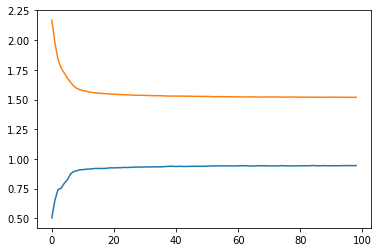

In [17]:
plt.plot(test_accuracy_history)
plt.plot(test_loss_history);